<a href="https://colab.research.google.com/github/IronicNinja/Mathematical-Modeling/blob/master/Triathlon_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HiMCM 2016 Problem A - Triathlon

Below is the code that we used for our Mathematical Modeling final project. We present two separate algorithms in our paper, both of which are separately defined here. To play with the hyperparameters, please go to the "Algorithms" section of the Colab (which appears after our Exploratory Data Analysis).

In [ ]:
!pip install --upgrade gspread #required to read Google Sheets from Drive

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default()) #Connect to Google Drive. Make sure to authorize the application!

In [ ]:
"""Essential data science imports"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

"""Use Gspread to get the information from the spreadsheets"""
ws = gc.open('Triathlon Data')
sheet = ws.worksheet('Sort by Gender')
df = pd.DataFrame(sheet.get_all_records())
#print(df)
df.head() #View the dataframe

,BIB NO.,AGE,GENDER,CATEGORY,SWIM,T1,BIKE,T2,RUN,FINALTM,
0,1,33,M,M PRO,0:12:22,0:02:57,1:00:12,0:00:47,0:34:27,1:50:45,
1,2,32,M,M PRO,0:12:02,0:03:11,0:57:06,0:00:49,0:35:24,1:48:32,
2,3,31,M,M PRO,0:12:40,0:03:16,1:01:16,0:00:44,0:34:27,1:52:23,
3,4,28,M,M PRO,0:14:11,0:03:00,1:05:24,0:00:55,0:32:51,1:56:21,
4,5,27,M,M PRO,0:12:13,0:03:03,1:02:46,0:00:52,0:34:58,1:53:52,


# Exploratory Data Analysis (EDA)

We ask ourselves four questions:

1.   Does age correlate with a person's final time?
2.   Does a participant's time in any of the sections correlate with their final times? If so, which sections' times are most indicative of a successful/unsuccessful race?
3. What percentage of people are in each division?
4. What is the average time for each division?

By analyzing these questions, we can get a better sense of how the data is organized, and subsequently, be able to create a more accurate model with more fine-tuned hyperparameters.


In [ ]:
from datetime import datetime

# driver function for converting a time with type string into minutes
def convert_time(cat, i):
  final = df[cat][i].replace(' AM', '')
  person_time = ((datetime.strptime(final, '%H:%M:%S')-datetime(1900, 1, 1)).total_seconds()/60)
  return person_time

# Define three dictionaries which we will use later
num_of_ppl = {'M PRO': 0, 'M PREMIER': 0, 'M OPEN': 0, 'F PRO': 0, 'F PREMIER': 0, 'F OPEN': 0, 'CLY': 0, 'ATH': 0}
times = {'M PRO': 0, 'M PREMIER': 0, 'M OPEN': 0, 'F PRO': 0, 'F PREMIER': 0, 'F OPEN': 0, 'CLY': 0, 'ATH': 0}
all_times = {'M PRO': [[] for i in range(3)], 'M PREMIER': [[] for i in range(3)], 'M OPEN': [[] for i in range(3)], 'F PRO': [[] for i in range(3)], 
             'F PREMIER': [[] for i in range(3)], 'F OPEN': [[] for i in range(3)], 'CLY': [[] for i in range(3)], 'ATH': [[] for i in range(3)]}
section_times = {'M PRO': [[] for i in range(3)], 'M PREMIER': [[] for i in range(3)], 'M OPEN': [[] for i in range(3)], 'F PRO': [[] for i in range(3)], 
             'F PREMIER': [[] for i in range(3)], 'F OPEN': [[] for i in range(3)], 'CLY': [[] for i in range(3)], 'ATH': [[] for i in range(3)]}

for i in range(len(df)):
  # Dataframe has empty rows, when the code sees the first empty row, break
  if df['AGE'][i] == '':
    break

  category = df['CATEGORY'][i]
  num_of_ppl[category] += 1

  person_time = convert_time('FINALTM', i)
  times[category] += person_time

  # Below code is not necessarily optimized for time, but instead for space (minimize number of lines of code)
  all_times[category][0].append(convert_time('SWIM', i))
  all_times[category][1].append(convert_time('BIKE', i)+convert_time('SWIM', i)+convert_time('T1', i))
  all_times[category][2].append(convert_time('RUN', i)+convert_time('BIKE', i)+convert_time('SWIM', i)+convert_time('T1', i)+convert_time('T2', i)) #could also call 'FINALTM'

  section_times[category][0].append(convert_time('SWIM', i))
  section_times[category][1].append(convert_time('BIKE', i))
  section_times[category][2].append(convert_time('RUN', i))

Here, we will answer our first question: Does age correlate with a person's final time? Note, all code with "colors" in it is just for a fun colored scatter plot that we wanted to test out (we opted not to use it in our paper). The code below is a bit sloppy, but all you really need are the age_list and all_final_times.

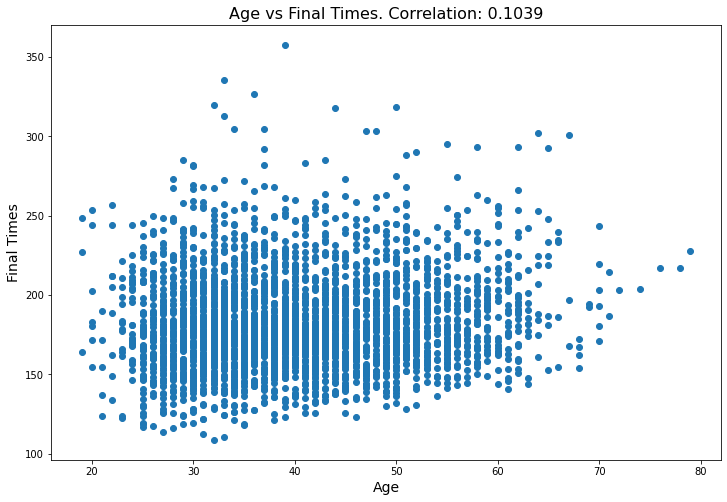

In [ ]:
age_list = []
all_final_times = []
curr_cat = df['CATEGORY'][0]
total_length = 0
colors = ['gray', 'cyan', 'red', 'yellow', 'purple', 'blue', 'gray', 'black'] #Fun colormap for the scatter plot (we opted not to use)
color_map = []
r = 0

for i in range(len(df)):
  if df['AGE'][i] == '':
    break

  total_length += 1
  if df['CATEGORY'][i] != curr_cat:
    r += 1
    curr_cat = df['CATEGORY'][i]
  color_map.append(colors[r])

  # Only important functions here
  age_list.append(df['AGE'][i])
  all_final_times.append(convert_time('FINALTM', i))

correlation = (np.corrcoef(age_list, all_final_times))[0][1]

plt.figure(figsize=(12,8))
plt.scatter(age_list, all_final_times)
plt.title("Age vs Final Times. Correlation: %.4f" % correlation, fontsize=16)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Final Times", fontsize=14)
plt.show()

Clearly, ages are not correlated with a participant's final time. Next, we will answer the question: Does a participant's time in any of the sections correlate with their final times? If so, which sections' times are most indicative of a successful/unsuccessful race?



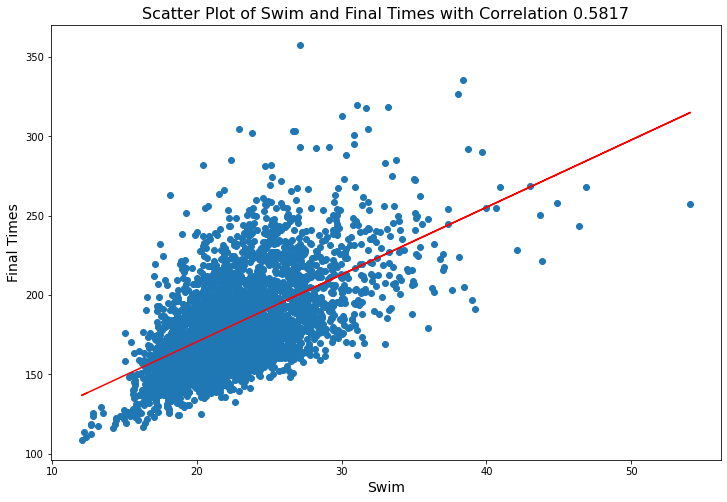

In [ ]:
def visualize(inputx, inputy, titlex, titley):
  # Convert to standard units and then calculate correlation (could also have just used a numpy library)
  l1 = np.array(inputx)
  l2 = np.array(inputy)
  l1_mean = np.mean(l1)
  l1_std = np.std(l1)
  l2_mean = np.mean(l2)
  l2_std = np.std(l2)
  x_su = (l1-l1_mean)/l1_std
  y_su = (l2-l2_mean)/l2_std

  r = np.mean(x_su*y_su)
  m, b = np.polyfit(l1, l2, 1)
  
  plt.figure(figsize=(12, 8))
  plt.title("Scatter Plot of %s and %s with Correlation %.4f" % (titlex, titley, r), fontsize=16)
  plt.scatter(l1, l2)
  plt.plot(l1, m*l1+b, color='r')
  plt.xlabel(titlex, fontsize=14)
  plt.ylabel(titley, fontsize=14)
  plt.show()

xinput = np.array([]) # Sectional Times
yinput = np.array([]) # Final Times
for cat in section_times:
  xinput = np.append(xinput, section_times[cat][0])
  yinput = np.append(yinput, all_times[cat][2])

visualize(xinput, yinput, "Swim", "Final Times")

Bike and run times are quite correlated with an athlete's final time, whereas swim time is not so much. Next, we will look at the percentage of people in each division.

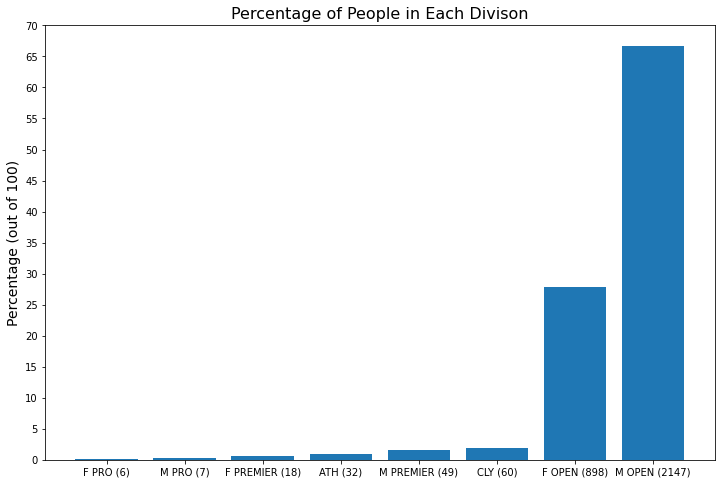

In [ ]:
def takesecond(elem):
  return elem[1]

labels_list = [cat for cat in all_times]

all_length_list = []
for l in labels_list:
  ind_length = len(all_times[l][2])
  all_length_list.append(["%s (%d)" % (l, ind_length), ind_length/total_length*100])

all_length_list.sort(key=takesecond)
ll_list = [l[0] for l in all_length_list] #Labels
length_list = [l[1] for l in all_length_list] #Numerical Values 

plt.figure(figsize=(12, 8))
plt.bar(ll_list, length_list)
plt.yticks(np.arange(0, 71, 5))
plt.title("Percentage of People in Each Divison", fontsize=16)
plt.ylabel("Percentage (out of 100)", fontsize=14)
plt.show()

Finally, we will answer the question of which divisions are the fastest.

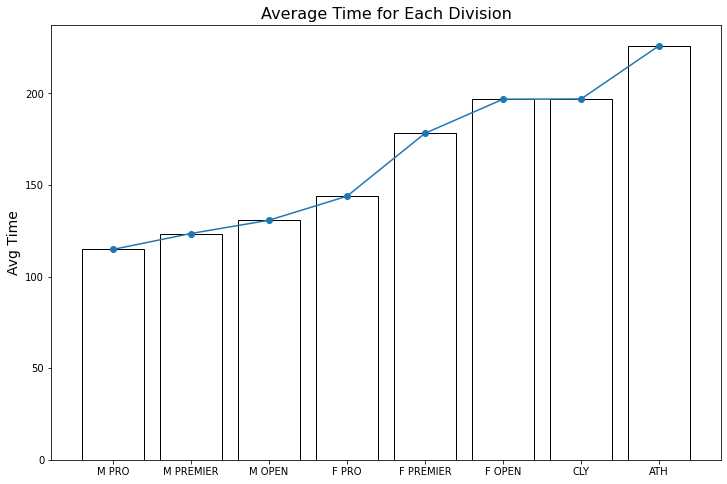

In [ ]:
avg_times = {'M PRO': 0, 'M PREMIER': 0, 'M OPEN': 0, 'F PRO': 0, 'F PREMIER': 0, 'F OPEN': 0, 'CLY': 0, 'ATH': 0}

for cat in times:
  avg_times[cat] = times[cat]/num_of_ppl[cat]

all_list = list(avg_times.items())
all_list.sort(key=takesecond)
times_list = [times[1] for times in all_list]

plt.figure(figsize=(12, 8))
plt.plot(times_list, marker='o')
plt.bar(labels_list, times_list, color='white', edgecolor='black')
plt.title("Average Time for Each Division", fontsize=16)
plt.ylabel("Avg Time", fontsize=14)
plt.show()

# Algorithms

In this section, we will present the algorithms we used for our paper. Further details are provided in our paper, so this section will mostly just include the code used.

In [ ]:
import math
expected_ppl = 2000
ratio = expected_ppl/total_length

def convert_ratio(cat, x):
  return np.array(all_times[cat][x][:math.ceil(ratio*len(all_times[cat][x]))])

def algo1(x, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait, plot=True, day1=False):
  
  ### Preprocessing ###
  mopen_shuffled = np.array(all_times['M OPEN'][x])
  np.random.shuffle(mopen_shuffled)
  mopen_shuffled = mopen_shuffled[:math.ceil(ratio*len(all_times['M OPEN'][x]))]
  mopen_split = np.array_split(mopen_shuffled, 2)

  fopen_shuffled = np.array(all_times['F OPEN'][x])
  np.random.shuffle(fopen_shuffled)
  fopen_shuffled = fopen_shuffled[:math.ceil(ratio*len(all_times['F OPEN'][x]))]
  fopen_split = np.array_split(fopen_shuffled, 2)

  ### Day 1 ###
  m1 = np.array_split(mopen_split[0], male_group)
  f1 = np.array_split(fopen_split[0], female_group)
  day_1 = m1.copy()
  for f in f1:
    day_1.append(f)
  day_1.append(convert_ratio('CLY', x))

  merged_list = np.array([])
  val1 = 0
  for i in range(len(day_1)):
    if i == 0:
      pass
    elif i == len(day_1)-1:
      val1 += cly_wait
    elif i == male_group:
      val1 += mf1_wait
    else:
      val1 += d1_wait

    day_1[i] += val1
    merged_list = np.append(merged_list, day_1[i])

  merged_list = merged_list.astype(np.int16)
  merged_list.sort()
  overlap_list = []
  cnt = 1
  curr = merged_list[0]
  for num in merged_list:
    if num > curr:
      overlap_list.append(cnt)
      cnt = 1
      curr = num
    else:
      cnt += 1

  over_time = np.count_nonzero(merged_list > 330)

  if plot:
    print(f"Max Overlap - {max(overlap_list)}\nMax Time Taken - {max(merged_list)}\nPeople Over 5.5 Hours - {over_time}")
    fig, ax = plt.subplots(1, 2, figsize=(30, 8))
    ax[0].set_title("Histogram with Max Overlap of %d with Max Time %d Minutes and %d People Over Time" % (max(overlap_list), max(merged_list), over_time), fontsize=16)
    ax[0].hist(merged_list, bins=np.arange(min(merged_list), max(merged_list)+1))

  if not plot and day1:
    return max(overlap_list), max(merged_list), over_time

  ### Day 2 ###
  m2 = np.array_split(mopen_split[1], male2_group)
  f2 = np.array_split(fopen_split[1], female2_group)

  pro_div = np.array(list(convert_ratio('M PRO', x)) + list(convert_ratio('F PRO', x)))
  premier_div = np.array(list(convert_ratio('M PREMIER', x)) + list(convert_ratio('F PREMIER', x)))

  day_2 = []
  day_2.append(pro_div)
  day_2.append(premier_div)

  for m in m2:
    day_2.append(m)

  for f in f2:
    day_2.append(f)

  day_2.append(convert_ratio('ATH', x))
  day_2 = np.array(day_2)

  merged_list = np.array([])
  val2 = 0
  for i in range(len(day_2)):
    if i == 0:
      pass
    elif i == 1:
      val2 += pro_premier_wait
    elif i == 2:
      val2 += premier_m_wait
    elif i == 2+male2_group:
      val2 += mf2_wait
    elif i == 2+male2_group+female2_group:
      val2 += ath_wait
    else:
      val2 += d2_wait

    day_2[i] += val2
    merged_list = np.append(merged_list, day_2[i])

  merged_list = merged_list.astype(np.int16)
  merged_list.sort()
  overlap_list = []
  cnt = 1
  curr = merged_list[0]
  for num in merged_list:
    if num > curr:
      overlap_list.append(cnt)
      cnt = 1
      curr = num
    else:
      cnt += 1

  over_time = np.count_nonzero(merged_list > 330)

  if plot:
    print(f"Max Overlap - {max(overlap_list)}\nMax Time Taken - {max(merged_list)}\nPeople Over 5.5 Hours - {over_time}")
    ax[1].set_title("Histogram with Max Overlap of %d with Max Time %d Minutes and %d People Over Time" % (max(overlap_list), max(merged_list), over_time), fontsize=16)
    ax[1].hist(merged_list, bins=np.arange(min(merged_list), max(merged_list)+1))
    plt.show()
  else:
    return max(overlap_list), max(merged_list), over_time

In [ ]:
def algo2(x, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait, plot=True, day1=False):
  
  ### Preprocessing ###
  mopen_shuffled = np.array(all_times['M OPEN'][x])
  np.random.shuffle(mopen_shuffled)
  mopen_shuffled = mopen_shuffled[:math.ceil(ratio*len(all_times['M OPEN'][x]))]
  mopen_split = np.array_split(mopen_shuffled, 2)

  fopen_shuffled = np.array(all_times['F OPEN'][x])
  np.random.shuffle(fopen_shuffled)
  fopen_shuffled = fopen_shuffled[:math.ceil(ratio*len(all_times['F OPEN'][x]))]
  fopen_split = np.array_split(fopen_shuffled, 2)

  ### Day 1 ###
  m1 = np.array_split(mopen_split[0], male_group)
  f1 = np.array_split(fopen_split[0], female_group)
  day_1 = []
  day_1.append(convert_ratio('CLY', x))

  for f in f1:
    day_1.append(f)

  for m in m1:
    day_1.append(m)

  merged_list = np.array([])
  val1 = 0
  for i in range(len(day_1)):
    if i == 0:
      pass
    elif i == 1:
      val1 += cly_wait
    elif i == female_group+1:
      val1 += mf1_wait
    else:
      val1 += d1_wait

    day_1[i] += val1
    merged_list = np.append(merged_list, day_1[i])

  merged_list = merged_list.astype(np.int16)
  merged_list.sort()
  overlap_list = []
  cnt = 1
  curr = merged_list[0]
  for num in merged_list:
    if num > curr:
      overlap_list.append(cnt)
      cnt = 1
      curr = num
    else:
      cnt += 1

  over_time = np.count_nonzero(merged_list > 330)

  if plot:
    print(f"Max Overlap - {max(overlap_list)}\nMax Time Taken - {max(merged_list)}\nPeople Over 5.5 Hours - {over_time}")
    fig, ax = plt.subplots(1, 2, figsize=(30, 8))
    ax[0].set_title("Histogram with Max Overlap of %d with Max Time %d Minutes and %d People Over Time" % (max(overlap_list), max(merged_list), over_time), fontsize=16)
    ax[0].hist(merged_list, bins=np.arange(min(merged_list), max(merged_list)+1))
  
  if not plot and day1:
    return max(overlap_list), max(merged_list), over_time

  ### Day 2 ###
  m2 = np.array_split(mopen_split[1], male2_group)
  f2 = np.array_split(fopen_split[1], female2_group)

  pro_div = np.array(list(convert_ratio('M PRO', x)) + list(convert_ratio('F PRO', x)))
  premier_div = np.array(list(convert_ratio('M PREMIER', x)) + list(convert_ratio('F PREMIER', x)))

  day_2 = []
  day_2.append(pro_div)
  day_2.append(premier_div)
  day_2.append(convert_ratio('ATH', x))

  for f in f2:
    day_2.append(f)

  for m in m2:
    day_2.append(m)

  day_2 = np.array(day_2)
  
  merged_list = np.array([])
  val2 = 0
  for i in range(len(day_2)):
    if i == 0:
      pass
    elif i == 1:
      val2 += pro_premier_wait
    elif i == 2:
      val2 += premier_m_wait
    elif i == 3:
      val2 += ath_wait
    elif i == 3+female2_group:
      val2 += mf2_wait
    else:
      val2 += d2_wait

    day_2[i] += val2
    merged_list = np.append(merged_list, day_2[i])

  merged_list = merged_list.astype(np.int16)
  merged_list.sort()
  overlap_list = []
  cnt = 1
  curr = merged_list[0]
  for num in merged_list:
    if num > curr:
      overlap_list.append(cnt)
      cnt = 1
      curr = num
    else:
      cnt += 1

  over_time = np.count_nonzero(merged_list > 330)

  if plot:
    print(f"Max Overlap - {max(overlap_list)}\nMax Time Taken - {max(merged_list)}\nPeople Over 5.5 Hours - {over_time}")
    ax[1].set_title("Histogram with Max Overlap of %d with Max Time %d Minutes and %d People Over Time" % (max(overlap_list), max(merged_list), over_time), fontsize=16)
    ax[1].hist(merged_list, bins=np.arange(min(merged_list), max(merged_list)+1))
    plt.show()
  else:
    return max(overlap_list), max(merged_list), over_time

Let's use the algorithms with the following hyperparameters (we decided not to use grid search here because we felt like it wasn't necessary when fine-tuning the hyperparameters). The meaning of each hyperparameter is detailed in our paper.


Max Overlap - 27
Max Time Taken - 378
People Over 5.5 Hours - 4
Max Overlap - 22
Max Time Taken - 339
People Over 5.5 Hours - 2


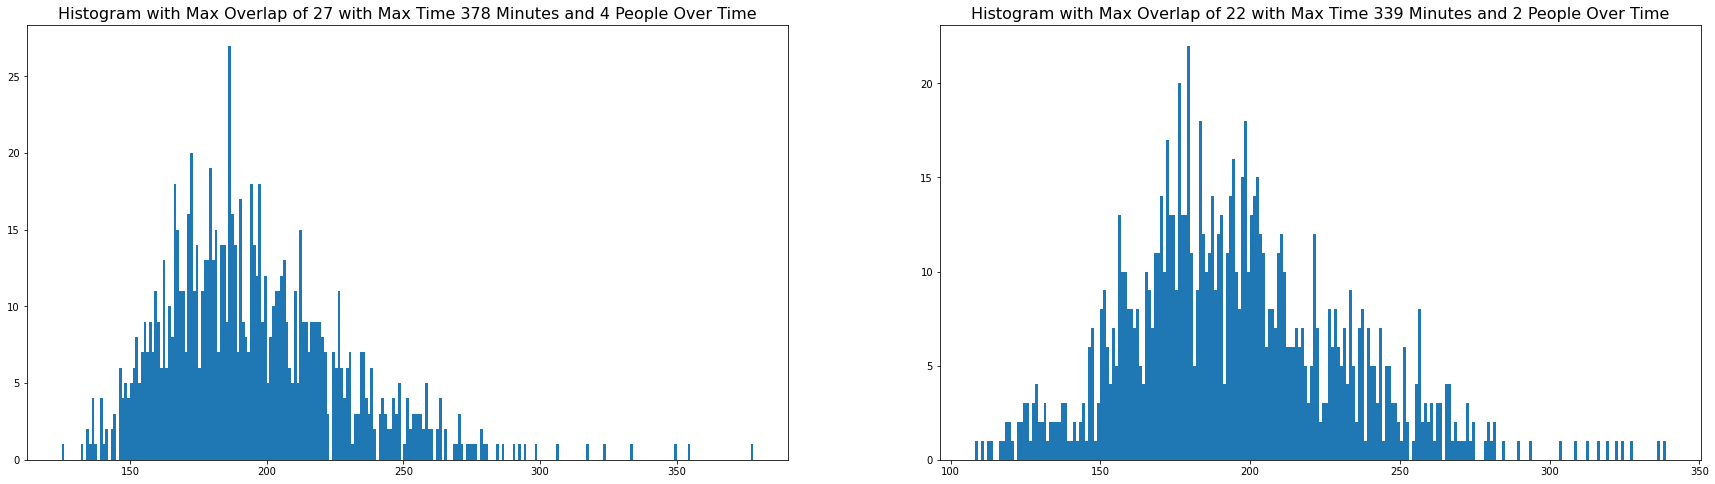

In [ ]:
male_group = 8
female_group = 4
d1_wait = 2
mf1_wait = 3
cly_wait = 1
# ----- #
male2_group = 8
female2_group = 4
d2_wait = 2
pro_premier_wait = 1
premier_m_wait = 1
mf2_wait = 3
ath_wait = 1

algo1(2, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait)

overlap1 = []
maxtime1 = []
overppl1 = []

for i in range(10000):
  overlap, maxtime, overppl = algo1(2, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait, plot=False, day1=True)
  overlap1.append(overlap)
  maxtime1.append(maxtime)
  overppl1.append(overppl)

Max Overlap - 25
Max Time Taken - 347
People Over 5.5 Hours - 2
Max Overlap - 22
Max Time Taken - 330
People Over 5.5 Hours - 0


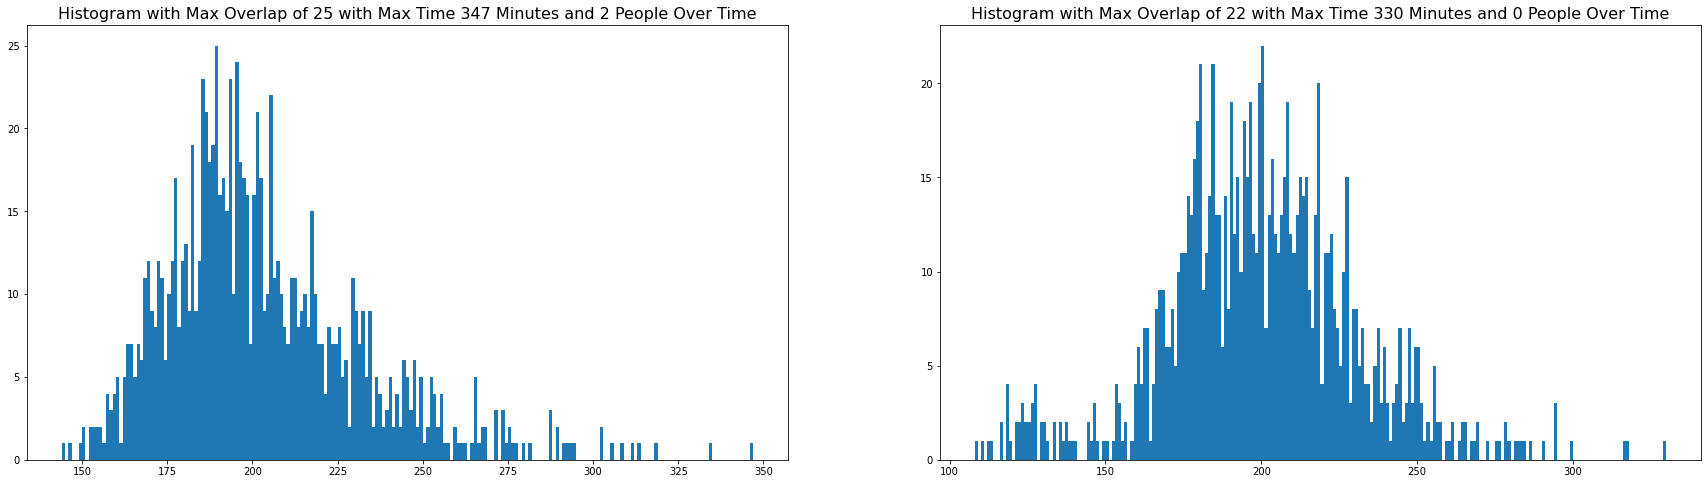

In [ ]:
male_group = 8
female_group = 4
d1_wait = 2
mf1_wait = 5
cly_wait = 6
# ----- #
male2_group = 8
female2_group = 4
d2_wait = 2
pro_premier_wait = 0
premier_m_wait = 1
mf2_wait = 5
ath_wait = 6

algo2(2, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait)

overlap2 = []
maxtime2 = []
overppl2 = []

for i in range(10000):
  overlap, maxtime, overppl = algo2(2, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait, plot=False, day1=True)
  overlap2.append(overlap)
  maxtime2.append(maxtime)
  overppl2.append(overppl)

We can print some of the aggregate data here. All data below is from Day 2.

In [ ]:
print("Day 1\nMax Overlap: %.3f +/- %.3f\nMax Time: %.3f +/- %.3f\nPeople Over Time: %.3f +/- %.3f" % (np.mean(overlap1), 2*np.std(overlap1),
                                                                                                       np.mean(maxtime1), 2*np.std(maxtime1),
                                                                                                       np.mean(overppl1), 2*np.std(overppl1)))

print("Day 2\nMax Overlap: %.3f +/- %.3f\nMax Time: %.3f +/- %.3f\nPeople Over Time: %.3f +/- %.3f" % (np.mean(overlap2), 2*np.std(overlap2),
                                                                                                       np.mean(maxtime2), 2*np.std(maxtime2),
                                                                                                       np.mean(overppl2), 2*np.std(overppl2)))

Day 1
Max Overlap: 21.279 +/- 4.060
Max Time: 352.925 +/- 38.321
People Over Time: 1.794 +/- 2.237
Day 2
Max Overlap: 23.950 +/- 4.537
Max Time: 342.772 +/- 35.982
People Over Time: 1.013 +/- 1.703


**Algorithm that Calculates Collisions**

Below is the code for calculating collisions. It has a similar style to the code for calculating congestion.



In [ ]:
def collision1(x, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait):
  mopen_shuffled = np.array(all_times['M OPEN'][x])
  #np.random.shuffle(mopen_shuffled) No shuffle
  mopen_shuffled = mopen_shuffled[:math.ceil(ratio*len(all_times['M OPEN'][x]))]
  mopen_split = np.array_split(mopen_shuffled, 2)

  fopen_shuffled = np.array(all_times['F OPEN'][x])
  #np.random.shuffle(fopen_shuffled)
  fopen_shuffled = fopen_shuffled[:math.ceil(ratio*len(all_times['F OPEN'][x]))]
  fopen_split = np.array_split(fopen_shuffled, 2)

  ### Day 1 ###
  m1 = np.array_split(mopen_split[0], male_group)
  day1_offsets = []
  f1 = np.array_split(fopen_split[0], female_group)
  day_1 = m1.copy()
  for f in f1:
    day_1.append(f)
  day_1.append(convert_ratio('CLY', x))

  merged_list = np.array([])
  val1 = 0
  for i in range(len(day_1)):
    if i == 0:
      pass
    elif i == len(day_1)-1:
      val1 += cly_wait
    elif i == male_group:
      val1 += mf1_wait
    else:
      val1 += d1_wait

    day_1[i] += val1
    day1_offsets += [val1]*len(day_1[i])
    merged_list = np.append(merged_list, day_1[i])

  merged_list = merged_list.astype(np.int16)
  day1_times = merged_list.astype(np.int16)
  merged_list.sort()
  overlap_list = []
  cnt = 1
  curr = merged_list[0]
  for num in merged_list:
    if num > curr:
      overlap_list.append(cnt)
      cnt = 1
      curr = num
    else:
      cnt += 1

  over_time = np.count_nonzero(merged_list > 330)

  ### Day 2 ###
  m2 = np.array_split(mopen_split[1], male2_group)
  f2 = np.array_split(fopen_split[1], female2_group)
  day2_offsets = []

  pro_div = np.array(list(convert_ratio('M PRO', x)) + list(convert_ratio('F PRO', x)))
  premier_div = np.array(list(convert_ratio('M PREMIER', x)) + list(convert_ratio('F PREMIER', x)))

  day_2 = []
  day_2.append(pro_div)
  day_2.append(premier_div)

  for m in m2:
    day_2.append(m)

  for f in f2:
    day_2.append(f)

  day_2.append(convert_ratio('ATH', x))
  day_2 = np.array(day_2)

  merged_list = np.array([])
  val2 = 0
  for i in range(len(day_2)):
    if i == 0:
      pass
    elif i == 1:
      val2 += pro_premier_wait
    elif i == 2:
      val2 += premier_m_wait
    elif i == 2+male2_group:
      val2 += mf2_wait
    elif i == 2+male2_group+female2_group:
      val2 += ath_wait
    else:
      val2 += d2_wait

    day_2[i] += val2
    day2_offsets += [val2]*len(day_2[i])
    merged_list = np.append(merged_list, day_2[i])

  day2_times = merged_list.astype(np.int16)
  merged_list = merged_list.astype(np.int16)
  merged_list.sort()
  overlap_list = []
  cnt = 1
  curr = merged_list[0]
  for num in merged_list:
    if num > curr:
      overlap_list.append(cnt)
      cnt = 1
      curr = num
    else:
      cnt += 1

  over_time = np.count_nonzero(merged_list > 330)

  return (day1_times, day1_offsets, day2_times, day2_offsets)

In [ ]:
def collision2(x, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait):
  mopen_shuffled = np.array(all_times['M OPEN'][x])
  #np.random.shuffle(mopen_shuffled) No shuffling
  mopen_shuffled = mopen_shuffled[:math.ceil(ratio*len(all_times['M OPEN'][x]))]
  mopen_split = np.array_split(mopen_shuffled, 2) 

  fopen_shuffled = np.array(all_times['F OPEN'][x])
  #np.random.shuffle(fopen_shuffled)
  fopen_shuffled = fopen_shuffled[:math.ceil(ratio*len(all_times['F OPEN'][x]))]
  fopen_split = np.array_split(fopen_shuffled, 2)

  ### Day 1 ###
  m1 = np.array_split(mopen_split[0], male_group)
  f1 = np.array_split(fopen_split[0], female_group)
  day1_offsets = []
  day_1 = []
  day_1.append(convert_ratio('CLY', x))

  for f in f1:
    day_1.append(f)

  for m in m1:
    day_1.append(m)

  merged_list = np.array([])
  val1 = 0
  for i in range(len(day_1)):
    if i == 0:
      pass
    elif i == 1:
      val1 += cly_wait
    elif i == female_group+1:
      val1 += mf1_wait
    else:
      val1 += d1_wait

    day_1[i] += val1
    day1_offsets += [val1]*len(day_1[i])
    merged_list = np.append(merged_list, day_1[i])

  day1_times = merged_list.astype(np.int16)
  merged_list = merged_list.astype(np.int16)
  merged_list.sort()
  overlap_list = []
  cnt = 1
  curr = merged_list[0]
  for num in merged_list:
    if num > curr:
      overlap_list.append(cnt)
      cnt = 1
      curr = num
    else:
      cnt += 1

  over_time = np.count_nonzero(merged_list > 330)

  ### Day 2 ###

  m2 = np.array_split(mopen_split[1], male2_group)
  f2 = np.array_split(fopen_split[1], female2_group)

  pro_div = np.array(list(convert_ratio('M PRO', x)) + list(convert_ratio('F PRO', x)))
  premier_div = np.array(list(convert_ratio('M PREMIER', x)) + list(convert_ratio('F PREMIER', x)))

  day2_offsets = []
  day_2 = []
  day_2.append(pro_div)
  day_2.append(premier_div)

  day_2.append(convert_ratio('ATH', x))

  for f in f2:
    day_2.append(f)

  for m in m2:
    day_2.append(m)

  day_2 = np.array(day_2)

  merged_list = np.array([])
  val2 = 0
  for i in range(len(day_2)):
    if i == 0:
      pass
    elif i == 1:
      val2 += pro_premier_wait
    elif i == 2:
      val2 += premier_m_wait
    elif i == 3:
      val2 += ath_wait
    elif i == 3+female2_group:
      val2 += mf2_wait
    else:
      val2 += d2_wait

    day_2[i] += val2
    day2_offsets += [val2]*len(day_2[i])
    merged_list = np.append(merged_list, day_2[i])

  day2_times = merged_list.astype(np.int16)
  merged_list = merged_list.astype(np.int16)
  merged_list.sort()
  overlap_list = []
  cnt = 1
  curr = merged_list[0]
  for num in merged_list:
    if num > curr:
      overlap_list.append(cnt)
      cnt = 1
      curr = num
    else:
      cnt += 1

  over_time = np.count_nonzero(merged_list > 330)

  return (day1_times, day1_offsets, day2_times, day2_offsets)

In [ ]:
# Algorithm 1

male_group = 8
female_group = 4
d1_wait = 2
mf1_wait = 3
cly_wait = 1
# ----- #
male2_group = 8
female2_group = 4
d2_wait = 2
pro_premier_wait = 1
premier_m_wait = 1
mf2_wait = 3
ath_wait = 1

swim = collision1(0, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait)
bike = collision1(1, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait)
run = collision1(2, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait)

In [ ]:
# Algorithm 2

male_group = 8
female_group = 4
d1_wait = 2
mf1_wait = 5
cly_wait = 6
# ----- #
male2_group = 8
female2_group = 4
d2_wait = 2
pro_premier_wait = 0
premier_m_wait = 1
mf2_wait = 5
ath_wait = 6

swim = collision2(0, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait)
bike = collision2(1, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait)
run = collision2(2, male_group, female_group, d1_wait, mf1_wait, cly_wait, male2_group, female2_group,
         d2_wait, pro_premier_wait, premier_m_wait, mf2_wait, ath_wait)

Note, this algorithm is static, as in it relies on the indices of the arrays to correspond with each other. Future work would make this a simulation by creating a list of lists, where each index in that list corresponds to one person (essentially merge separate lists).

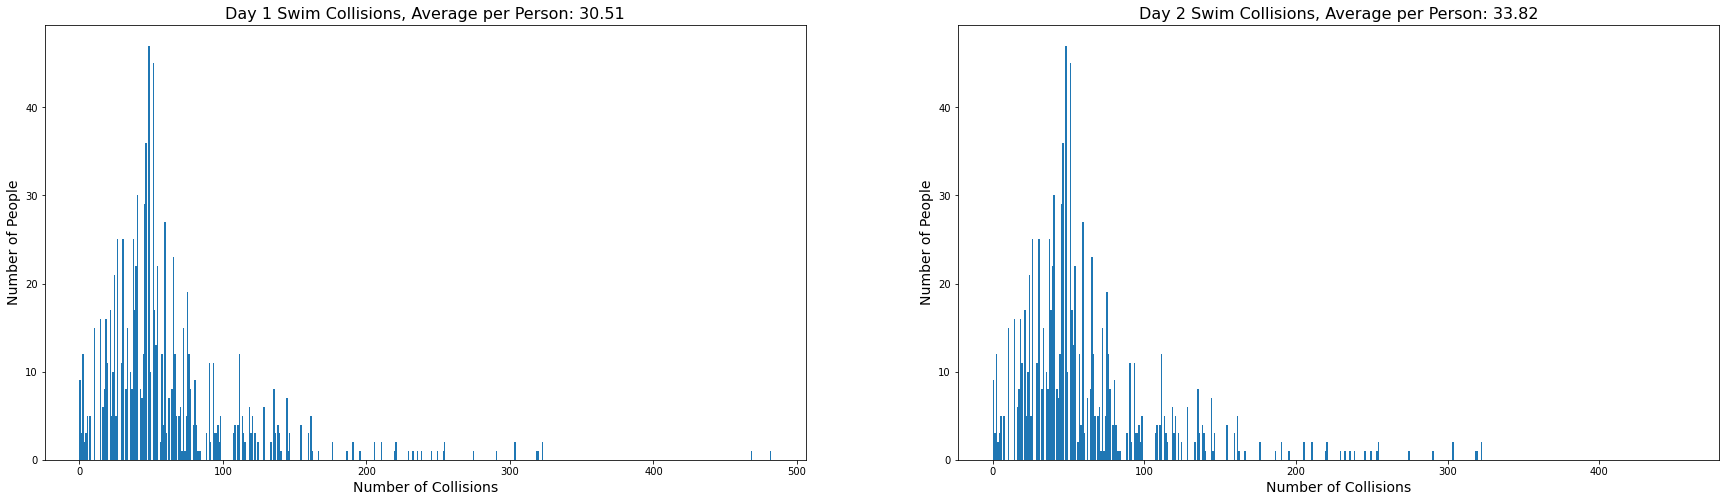

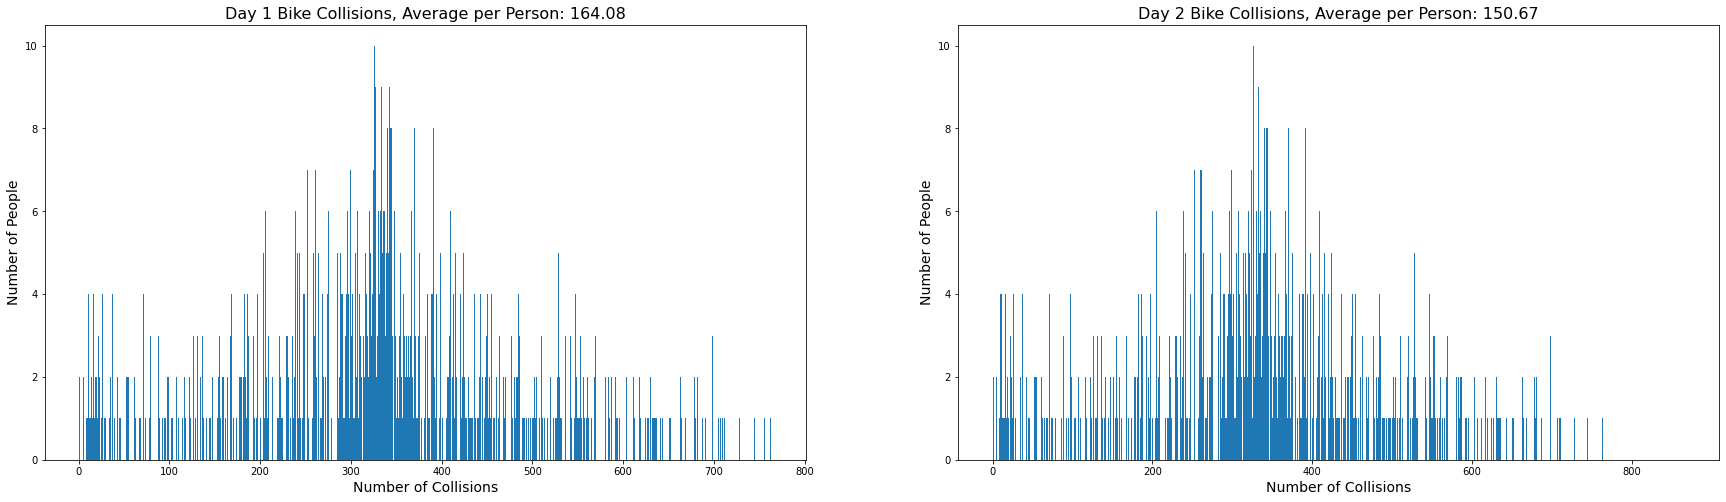

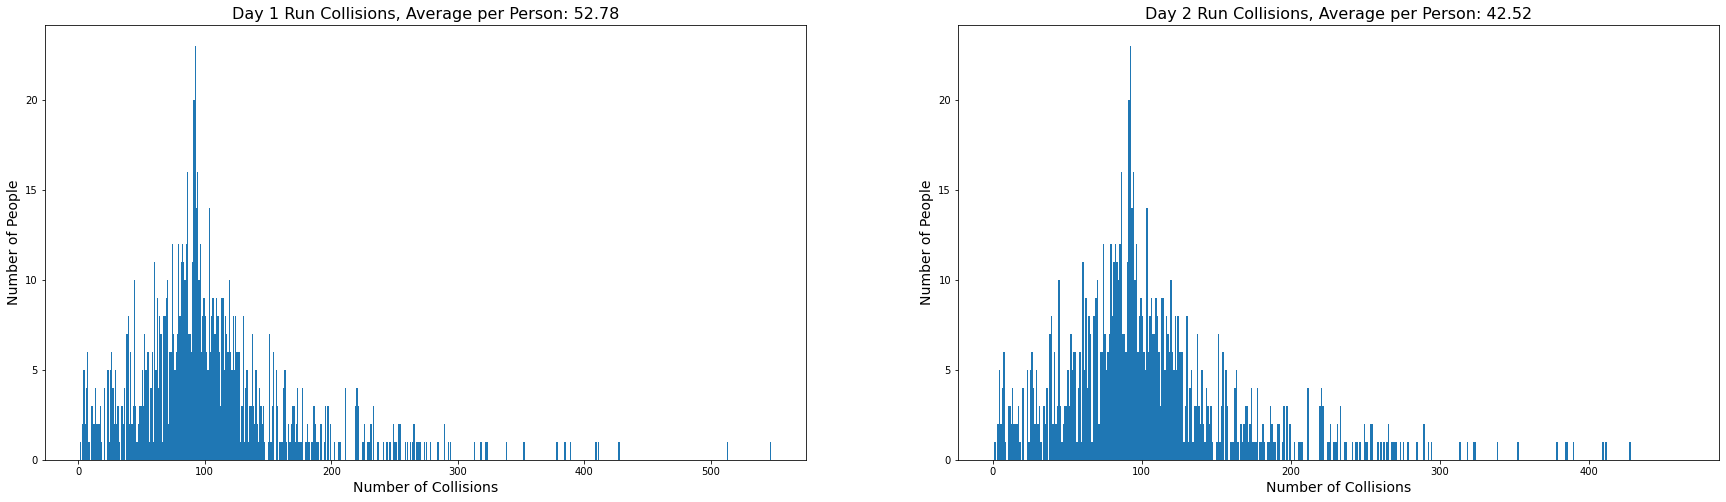

In [ ]:
day1_off = swim[1]
day2_off = swim[3]

day1_ordered = []
day1_ordered.append(day1_off)
day1_ordered.append(swim[0])
day1_ordered.append(bike[0])
day1_ordered.append(run[0])

day2_ordered = []
day2_ordered.append(day2_off)
day2_ordered.append(swim[2])
day2_ordered.append(bike[2])
day2_ordered.append(run[2])

def collision_algo(starting_index, ending_index, title):
  day1_collisions = [0] * len(day1_ordered[starting_index])
  day2_collisions = [0] * len(day2_ordered[starting_index])
  total_day1 = 0
  total_day2 = 0

  for i in range(len(day1_ordered[starting_index])):
    for j in range(len(day1_ordered[starting_index])):
        if i != j:
          if day1_ordered[starting_index][i] < day1_ordered[starting_index][j] and day1_ordered[ending_index][i] > day1_ordered[ending_index][j]: #if i starts before j but ends after j, then j passed i at some point
            day1_collisions[i] += 1
            day1_collisions[j] += 1
            total_day1 += 1

  for i in range(len(day2_ordered[starting_index])):
    for j in range(len(day2_ordered[starting_index])):
        if i != j:
          if day2_ordered[starting_index][i] < day2_ordered[starting_index][j] and day2_ordered[ending_index][i] > day2_ordered[ending_index][j]: #if i starts before j but ends after j, then j passed i at some point
            day2_collisions[i] += 1
            day2_collisions[j] += 1
            total_day2 += 1

  day1_avg = total_day1 / len(day1_ordered[starting_index])
  day2_avg = total_day2 / len(day2_ordered[starting_index])

  fig, ax = plt.subplots(1, 2, figsize=(30, 8))
  ax[0].set_title("Day 1 %s Collisions, Average per Person: %.2f" % (title, day1_avg), fontsize=16)
  ax[0].hist(day1_collisions, bins=np.arange(min(day1_collisions), max(day1_collisions)+1))
  ax[0].set_xlabel("Number of Collisions", fontsize=14)
  ax[0].set_ylabel("Number of People", fontsize=14)

  ax[1].set_title("Day 2 %s Collisions, Average per Person: %.2f" % (title, day2_avg), fontsize=16)
  ax[1].hist(day1_collisions, bins=np.arange(min(day2_collisions), max(day2_collisions)+1))
  ax[1].set_xlabel("Number of Collisions", fontsize=14)
  ax[1].set_ylabel("Number of People", fontsize=14)

  plt.show()

collision_algo(0,1, "Swim")
collision_algo(1,2, "Bike")
collision_algo(2,3, "Run")